# Predicting resell value for cars

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value.

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

<div class="alert alert-block alert-warning">
<b></b> <a class="tocSkip"></a>   
    
> # Contents <a id='back'></a>
> * [Introduction](#intro)
    * [Stage 1. Importing libraries](#Import-Libraries)
    * [Stage 2. Data Preparation](#Data-Preparation)
    * [Stage 3. Data Processing](#Data-Processing)
    * [Stage 4. Analyze data](#Analyze-data)
    * [Stage 5. Build model](#Build-model)
> * [Conclusion](#Conclusion)

# Importing Libraries

In [2]:
# data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
import time
# machine learning models

import catboost as cb
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV,cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, cv, Pool
from lightgbm import LGBMRegressor
# import warnings
# warnings.filterwarnings("ignore")

# Data Preparation

### Importing data

In [3]:
try:
    df_car = pd.read_csv('/Users/dankeichow/Downloads/car_data.csv')

except:
    df_car = pd.read_csv('/datasets/car_data.csv')

In [4]:
df_car.info()


df_car.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


At a quick glance,

1. Date crawled, date created and last seen columns are not in date format
2. There are missing values in verhicle type, gearbox, fuel type, not repaired
3. columns are not in lower case

We may not have to keep all columns for our models. Our **target** column with be `price`.

Columns that are useful to training:

- VehicleType — vehicle body type

- RegistrationYear — vehicle registration year

- Gearbox — gearbox type

- Power — power (hp)

- Model — vehicle model

- Mileage — mileage (measured in km due to dataset's regional specifics)

- FuelType — fuel type

- Brand — vehicle brand

- RegistrationMonth — vehicle registration month

- NotRepaired — vehicle repaired or not

Columns that seem irrelevant to training our model:

- DateCrawled — when did the data downloaded from database seems irrelevant to determine car price

- DateCreated — when was the profile created also seems irrelevant

- NumberOfPictures — having good photos maybe attract potential viewing but the number of vehicle pictures seems irrelevant

- PostalCode — potentially certain postal code can have higher sales but it will not determine the price of the car

- LastSeen — date of the last activity of the user will be irrelevant

Next, I will convert columns to lower case, check if there are duplicates and then drop irrelevant columns.

### Change column name to lower case

In [5]:
# Update columns to lowercase

df_car = df_car.rename(columns=lambda x: x.lower())

In [6]:
df_car.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'mileage', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

Column names are all in lower case now.

### Are there duplicates?

In [7]:
# Check if there are duplicates in the data set

print('There are',df_car.duplicated().sum() , 'duplicated rows. Now, we will drop the duplicates.')

There are 262 duplicated rows. Now, we will drop the duplicates.


In [8]:
# Dropping duplicates

df_car = df_car.drop_duplicates().reset_index(drop=True)

print('There are',df_car.duplicated().sum() , 'duplicated rows.')

There are 0 duplicated rows.


### Dropping irrelevant columns

In [9]:
# Dropping irrelevant columns

df_car = df_car.drop(['datecrawled','datecreated','lastseen','numberofpictures','postalcode'], axis=1)

In [10]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354107 entries, 0 to 354106
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354107 non-null  int64 
 1   vehicletype        316623 non-null  object
 2   registrationyear   354107 non-null  int64 
 3   gearbox            334277 non-null  object
 4   power              354107 non-null  int64 
 5   model              334406 non-null  object
 6   mileage            354107 non-null  int64 
 7   registrationmonth  354107 non-null  int64 
 8   fueltype           321218 non-null  object
 9   brand              354107 non-null  object
 10  notrepaired        282962 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


### Examine data

There are missing data in in `vehicletype`, `gearbox`, `model`, `fueltype`, and `notrepaired`.

Let's understand the data a bit more in depth with columne that do not have nulls before filling in the NAs.

In [11]:
# First, let's check the % of missing data of

((df_car.isnull().sum()/df_car.shape[0])*100).sort_values(ascending=False)

notrepaired          20.091385
vehicletype          10.585501
fueltype              9.287871
gearbox               5.600002
model                 5.563573
price                 0.000000
registrationyear      0.000000
power                 0.000000
mileage               0.000000
registrationmonth     0.000000
brand                 0.000000
dtype: float64

Let examine `registrationyear` where is has no missing data to make sure years are relevant.

In [12]:
df_car['registrationyear'].value_counts()

registrationyear
2000    24476
1999    22703
2005    22094
2001    20107
2006    19874
        ...  
6500        1
2290        1
1001        1
9450        1
3500        1
Name: count, Length: 151, dtype: int64

It seems like there are odd years in the data. There are year 3500, 9450 or 1001. Let's refine the years of data.

In [13]:
df_car = df_car[(df_car['registrationyear'] >= 1970) & (df_car['registrationyear'] <= 2022)]


In [14]:
print('After refining the years of car sales, we have', df_car.shape[0], 'rows of data.')

After refining the years of car sales, we have 352665 rows of data.


Let's examine `price`, `power` and `registrationmonth`

In [15]:
# Examining price column

df_car['price'].value_counts()

price
0        10588
500       5645
1500      5379
1000      4633
1200      4583
         ...  
3021         1
1368         1
233          1
11080        1
10985        1
Name: count, Length: 3727, dtype: int64

In [16]:
df_car.loc[df_car['price'] == 0]

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no
40,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN
111,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN
115,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN
152,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes
...,...,...,...,...,...,...,...,...,...,...,...
353943,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes
353976,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN
353986,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN
354015,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes


If the price is zero, the model will learn that there are cars that can be priced at 0. If we look at row 111, the car only has 5000 miles and registered in 2017, it seems more like 0 maybe be a data entry error before data was crawled or downloaded. Therefore, we will remove 0.

In [17]:
# Excluding price = 0

df_car = df_car.loc[df_car['price']!= 0]

df_car.shape[0]

342077

In [18]:
# Checking registrationmonth column

df_car['registrationmonth'].value_counts()

registrationmonth
3     33696
0     32551
6     30698
4     28608
5     28436
7     26465
10    25552
12    23724
11    23715
9     23320
1     22500
8     22066
2     20746
Name: count, dtype: int64

In [19]:
df_car['power'].value_counts()

power
0       35852
75      23270
60      15418
150     14139
101     12945
        ...  
2331        1
2789        1
519         1
2461        1
1241        1
Name: count, Length: 693, dtype: int64

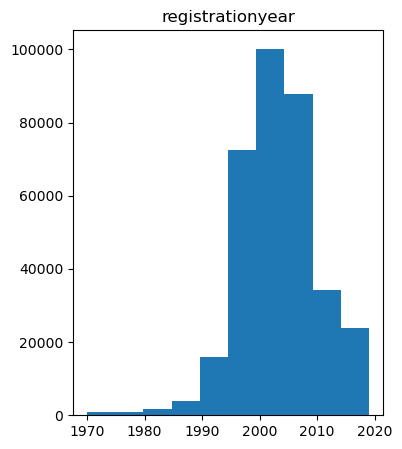

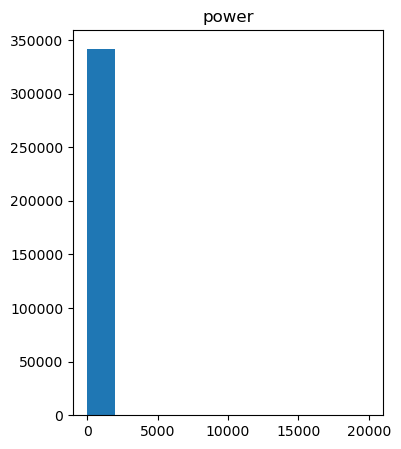

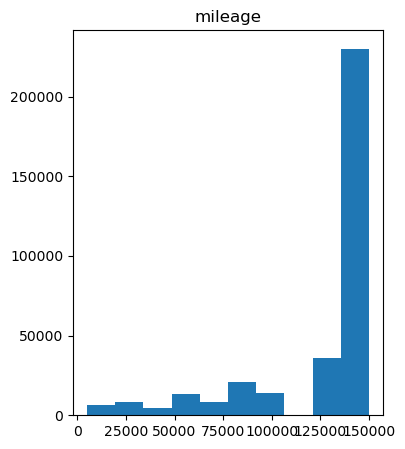

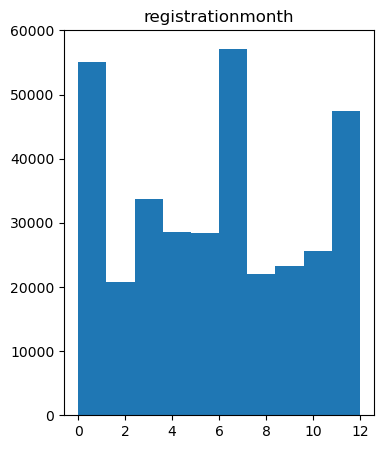

In [20]:
num_column = ['registrationyear','power','mileage','registrationmonth']

for each_num_col in num_column:
    plt.figure(figsize=(4,5))
    plt.hist(df_car[each_num_col])
    plt.title(each_num_col)
    plt.show()



**Observation**

Majority of the car registration years are mid 1990s to mid 2010s. Both mileage and registration year are negatively skewed. There are more registration during January, July and December. I am not familiar with cars but assuming there maybe summer sale and year end sale that may bump the number

In [21]:
# Examine rows with 0 month

df_car.loc[df_car['registrationmonth'] == 0]

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
9,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN
16,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN
36,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN
54,4700,wagon,2005,manual,0,signum,150000,0,NaN,opel,no
...,...,...,...,...,...,...,...,...,...,...,...
354043,3500,NaN,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN
354056,400,wagon,1991,manual,0,legacy,150000,0,petrol,subaru,NaN
354064,1300,small,1999,manual,75,2_reihe,125000,0,NaN,peugeot,NaN
354067,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN


In [22]:
# Excluding registrationmonth with 0

df_car = df_car.loc[df_car['registrationmonth']!= 0]

df_car.shape[0]

309526

It seems like an error where registration month can be zero. There are only 12 months in a year and no 0 month. Therefore, we will remove month with zeor.

In [23]:
# Checking power column

df_car['power'].value_counts()

power
0       23332
75      21069
60      13923
150     13092
140     12218
        ...  
2789        1
519         1
585         1
2461        1
1241        1
Name: count, Length: 662, dtype: int64

In [24]:
# Examine rows with 0 power

df_car.loc[df_car['power'] == 0]

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired
32,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no
37,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no
55,550,wagon,1999,manual,0,astra,150000,8,gasoline,opel,yes
70,800,small,1993,manual,0,polo,150000,3,petrol,volkswagen,no
90,2400,sedan,2003,manual,0,a4,150000,9,gasoline,audi,NaN
...,...,...,...,...,...,...,...,...,...,...,...
354074,3299,NaN,2005,auto,0,outlander,150000,4,petrol,mitsubishi,NaN
354076,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN
354084,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN
354101,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no


There seems to be another error where power is 0. If there is no power, how could a car move? Therefore, we will remove the 0s.

In [25]:
# Exclude rows with 0

df_car = df_car.loc[df_car['power']!= 0]

df_car.info()

<class 'pandas.core.frame.DataFrame'>
Index: 286194 entries, 1 to 354106
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              286194 non-null  int64 
 1   vehicletype        270353 non-null  object
 2   registrationyear   286194 non-null  int64 
 3   gearbox            282010 non-null  object
 4   power              286194 non-null  int64 
 5   model              276400 non-null  object
 6   mileage            286194 non-null  int64 
 7   registrationmonth  286194 non-null  int64 
 8   fueltype           271564 non-null  object
 9   brand              286194 non-null  object
 10  notrepaired        249111 non-null  object
dtypes: int64(5), object(6)
memory usage: 26.2+ MB


### Missing data

There are missing data in in `vehicletype`, `gearbox`, `model`, `fueltype`, and `notrepaired`. These are all categorical columns, meaning we are unable to fill the null with a mean or median. All these columsn are also in string format. For example, there is no median or mean to vehicletype. Therefore, will fill it for unknown first.

In [26]:
# Filling NA with a string 'unknown'

df_car = df_car.fillna('unknown')

df_car.isna().sum()

price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
mileage              0
registrationmonth    0
fueltype             0
brand                0
notrepaired          0
dtype: int64

In [27]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
Index: 286194 entries, 1 to 354106
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              286194 non-null  int64 
 1   vehicletype        286194 non-null  object
 2   registrationyear   286194 non-null  int64 
 3   gearbox            286194 non-null  object
 4   power              286194 non-null  int64 
 5   model              286194 non-null  object
 6   mileage            286194 non-null  int64 
 7   registrationmonth  286194 non-null  int64 
 8   fueltype           286194 non-null  object
 9   brand              286194 non-null  object
 10  notrepaired        286194 non-null  object
dtypes: int64(5), object(6)
memory usage: 26.2+ MB


We have performed the followings to prepare our data for training:
1. Rename all columns to lowercase
2. Remove duplicates
3. Drop rows with 0 values
4. Drop columns that are not relevant to training our model

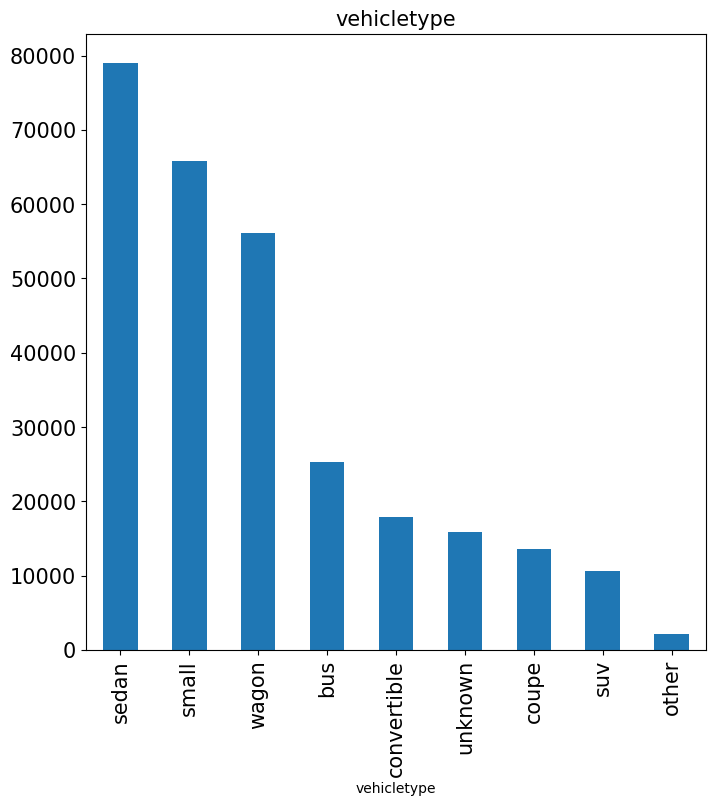

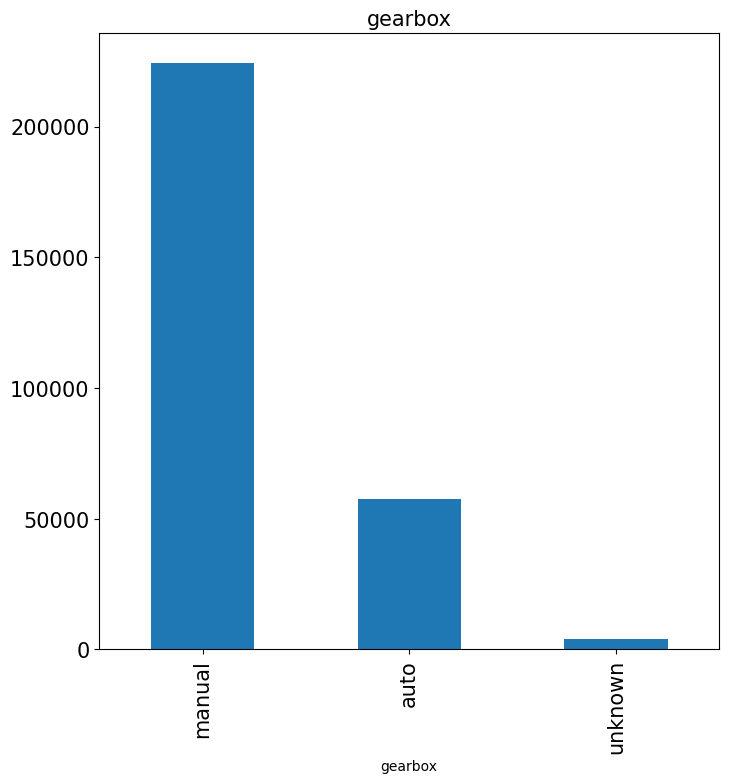

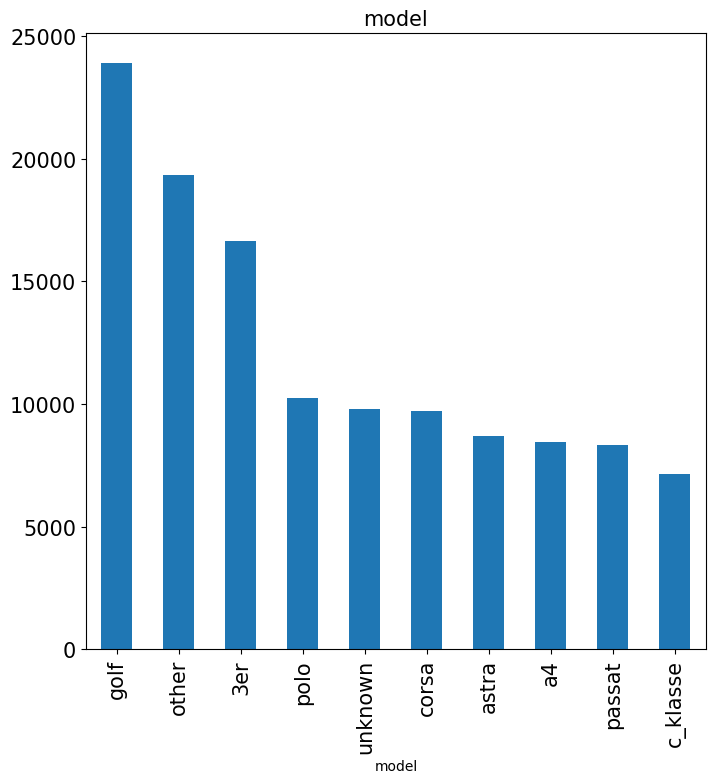

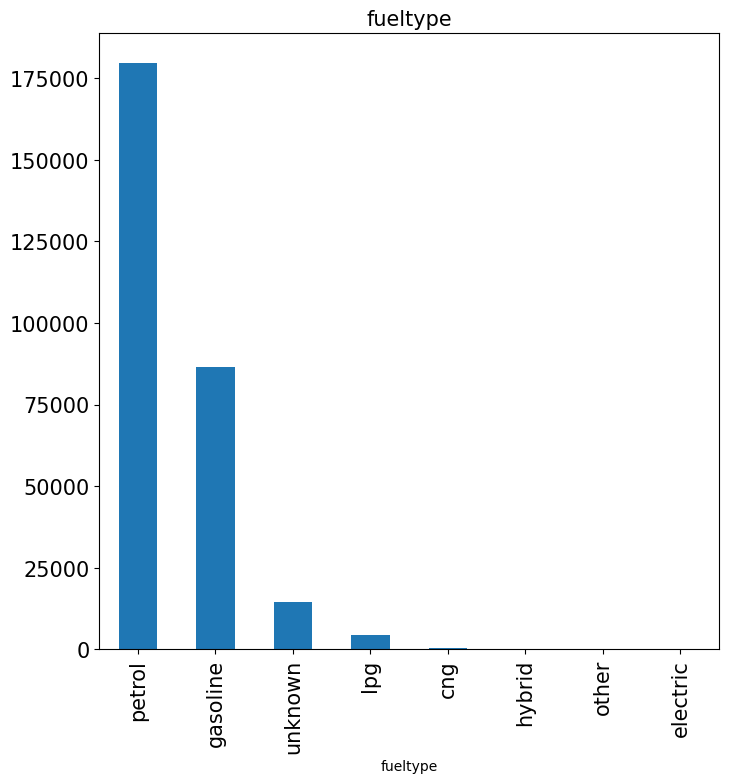

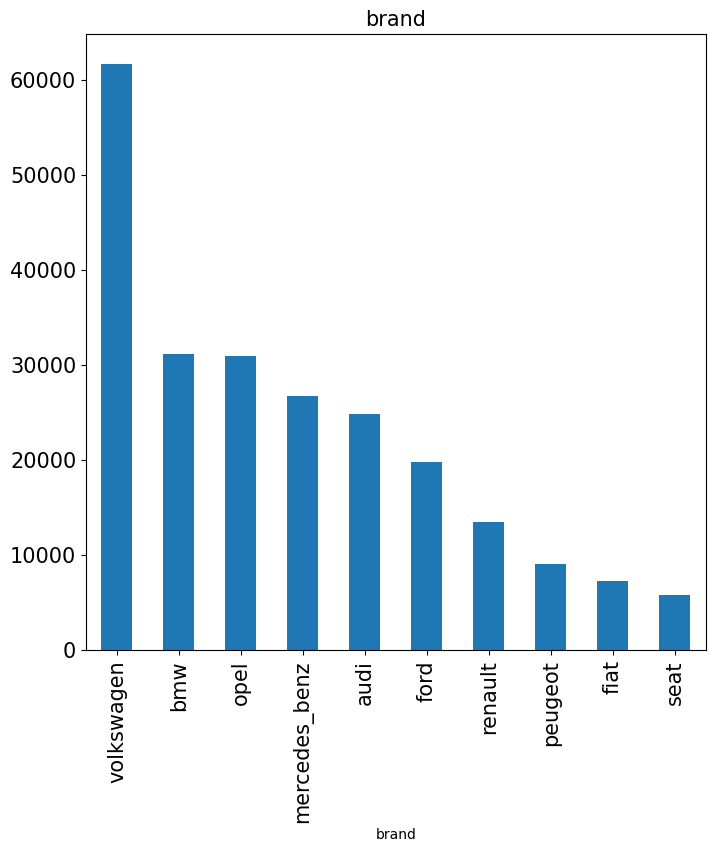

In [28]:
cat_columns = ['vehicletype','gearbox','model','fueltype','brand']

for each_col in cat_columns:
    plt.figure()
    df_car[each_col].value_counts()[:10].plot(kind='bar', figsize=(8,8))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(each_col, fontsize=15)
    plt.show()

**Observation**

Sedan is the most popular vehicle type. Manual is most popular gearbox type. Volkswagen is also the most popular brands. It seems like Volkswagen dominates the market share in the area that Rusty Bargin operates in.

# Data Processing

### Categorical data transformation

Before we train test split the data, we will transform the categorical columns to values. Afterwards, we will scale all columns to make them equally scaled.

For catboost, we do not need to encode the ecategorical columns. However, we need the categorical columns to be encoded for linear regression, decision tree and random forest. Therefore, we will create 2 different sets of features and target.

In [29]:
# Make a copy of the data for when we need it

df_car_copy = df_car.copy()

In [30]:
# Use one hot encoding to transform categorical columns to numerical

df_car_ohe = pd.get_dummies(df_car)

df_car_ohe

,price,registrationyear,power,mileage,registrationmonth,vehicletype_bus,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,...,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_no,notrepaired_unknown,notrepaired_yes
1,18300,2011,190,125000,5,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
2,9800,2004,163,125000,8,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,1500,2001,75,150000,6,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False
4,3600,2008,69,90000,7,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
5,650,1995,102,150000,10,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354099,5250,2016,150,150000,12,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
354100,3200,2004,225,150000,5,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
354104,1199,2000,101,125000,3,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
354105,9200,1996,102,150000,3,True,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False


### Train test split after OHE for linear regression, decision tree and random forest

In [31]:
# Create features and test set

features_lr = df_car_ohe.drop(['price'],axis=1)

target_lr = df_car_ohe['price']

In [32]:
# Train test split

features_lr_train, features_lr_test, target_lr_train, target_lr_test = train_test_split(features_lr,
                                                                                        target_lr,
                                                                                        test_size = 0.2,
                                                                                        random_state=12345)

print(features_lr_train.shape,
      features_lr_test.shape,
      target_lr_train.shape,
      target_lr_test.shape)

(228955, 317) (57239, 317) (228955,) (57239,)


### Train test split data for catboost

In [33]:
# Creating features and target

features_bst = df_car_copy.drop(['price'],axis=1)

target_bst = df_car_copy['price']

# Train test split


features_bst_train, features_bst_test, target_bst_train, target_bst_test = train_test_split(features_bst,
                                                                                        target_bst,
                                                                                        test_size = 0.2,
                                                                                        random_state=12345)

print(features_bst_train.shape,
     features_bst_test.shape,
     target_bst_train.shape,
     target_bst_test.shape)

(228955, 10) (57239, 10) (228955,) (57239,)


### Scaling the data

We can see the  `registrationyear`, `power` and `mileage` are all in different scales. `Mileage` and `price` can heavily skew the model and trick the model to place higher importance than registration month. Therefore, we will standardize the scale.

In [34]:
from sklearn.preprocessing import StandardScaler

# Use StandardScaler to scale the columnes needed for data for LR, DT, RF

numeric = ['registrationyear',
          'power',
          'mileage']

scaler = StandardScaler()
scaler.fit(features_lr_train[numeric])
features_lr_train[numeric] = scaler.transform(features_lr_train[numeric])
features_lr_test[numeric] = scaler.transform(features_lr_test[numeric])

features_lr_train.head(8)

,registrationyear,power,mileage,registrationmonth,vehicletype_bus,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,...,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_no,notrepaired_unknown,notrepaired_yes
182756,-0.997761,-0.271127,0.597270,8,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
259610,1.770372,-0.304029,-3.349472,7,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
152917,-0.536405,-0.386287,0.597270,6,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
308230,-0.228835,0.112741,-1.035865,10,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
259143,0.232520,-0.353384,-0.083203,6,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
238523,-0.228835,0.140160,0.597270,3,False,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
304239,1.155231,0.414352,-2.124621,6,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
86028,0.693876,0.085322,0.597270,9,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [35]:
# Use StandardScaler to scale the columnes needed for data for catboost

scaler = StandardScaler()
scaler.fit(features_bst_train[numeric])
features_bst_train[numeric] = scaler.transform(features_bst_train[numeric])
features_bst_test[numeric] = scaler.transform(features_bst_test[numeric])

features_bst_train.head(8)

,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired
182756,small,-0.997761,manual,-0.271127,fiesta,0.597270,8,petrol,ford,no
259610,small,1.770372,manual,-0.304029,500,-3.349472,7,petrol,fiat,no
152917,unknown,-0.536405,manual,-0.386287,micra,0.597270,6,unknown,nissan,no
308230,sedan,-0.228835,auto,0.112741,c_klasse,-1.035865,10,petrol,mercedes_benz,unknown
259143,small,0.232520,manual,-0.353384,ka,-0.083203,6,petrol,ford,no
238523,sedan,-0.228835,manual,0.140160,octavia,0.597270,3,petrol,skoda,no
304239,coupe,1.155231,manual,0.414352,other,-2.124621,6,petrol,peugeot,no
86028,wagon,0.693876,manual,0.085322,mondeo,0.597270,9,gasoline,ford,no


# Model training

### Linear regression

In [36]:
# Initiate the model

lr = LinearRegression()


### Random Forest: using RandomizedSeachCV to get a range of best hyperparameters

In [37]:
# Create a dictionary for hyperparameters

param_dict_df = {'n_estimators': randint(1,15),
                'max_depth': randint(1,8)}

# Initiate random forest model

rf_search = RandomForestRegressor(random_state=12345)

# Using Randomizedsearchcv to find best parameters

rf_rand_search = RandomizedSearchCV(rf_search, param_dict_df, cv=5)

# Getting the best range of parameters

rf_rand_best = rf_rand_search.fit(features_lr_train,target_lr_train).best_params_

print(rf_rand_best)

{'max_depth': 7, 'n_estimators': 5}


As RandomizedSearchCV always returns different best params within a range, I will pick max_depth=6 and n_estimators=8

In [38]:
rf = RandomForestRegressor(max_depth = 6, n_estimators = 8, random_state=12345)

### Decision Tree Regressor: using RandomizedSeachCV to get a range of best hyperparameters

In [ ]:
# Create a dictionary for hyperparameters

param_dt = {'max_depth': randint(1,20)}

# Initiate deicision tree model

dt_search = DecisionTreeRegressor(random_state=12345)

# Using RandomizedSearchCV to find best param

df_rand_search = RandomizedSearchCV(dt_search, param_dt, cv=5)

# Getting the best range parameters

df_rand_best = df_rand_search.fit(features_lr_train,target_lr_train).best_params_

print(df_rand_best)

As RandomizedSearchCV always returns different best params within a range, I will pick max_depth=16

In [ ]:
dt = DecisionTreeRegressor(max_depth=15,random_state=12345)

### RMSE and time for above models

In [ ]:
# Store all models in a list

models = [lr, rf, dt]

# Create a dataframe to store data of the model

score_time = pd.DataFrame(columns = ['Linear Regression','Random Forest','Decision Tree'])

# Create empty lists for score and time

process_time = []
prediction_time = []
rmse = []

for each_model in models:
    start_process = time.time()
    each_model.fit(features_lr_train, target_lr_train)
    end_process = time.time()
    process_time.append(round(end_process - start_process, 5))

    start_predict = time.time()
    prediction_test = each_model.predict(features_lr_test)
    end_predict = time.time()
    prediction_time.append(end_predict - start_predict)

    mse = round(mean_squared_error(target_lr_test, prediction_test),2)
    rmse_value = round(mse **0.5,2)

    # Append the RMSE value to the list
    rmse.append(rmse_value)

score_time.loc['process_time'] = process_time
score_time.loc['prediction_time'] = prediction_time
score_time.loc['rmse'] = rmse

In [ ]:
score_time

**Observation**

It was already stated in the project that linear regression is used for sanity checking. We can see that it has the RMSE is extremely high. 2.606439e+07 = 2.606439 * 10^7 = 26,064,390. Decision tree seems to perform better than random forest. It has lower RMSE and lower fitting time.

### Catboost

In [ ]:
categorical =  ['vehicletype', 'gearbox', 'model', 'registrationmonth', 'fueltype', 'brand', 'notrepaired']

In [ ]:
# Create dictionary

cb_param_dict = {'depth': [6,8,10],
                'learning_rate': [0.01,0.05,0.1],
                 'l2_leaf_reg': [2,4],
                 'iterations': [10,20,30]
                }

# Initiate model
model_cb = CatBoostRegressor(loss_function = 'RMSE', random_state = 12345)

# Using GridSearchCV to find best parameter
grid=GridSearchCV(model_cb, param_grid=cb_param_dict, cv=5, verbose=10)


# Fitting the training data
grid.fit(features_bst_train, target_bst_train, cat_features = categorical)


In [ ]:
best_param = grid.best_params_
best_score = grid.best_score_

print('The best hyperparameters are', best_param, 'and best score is', best_score)

In [ ]:
#Initiate CatBoostRegressor with paramaters found from GridSearchCV
cb = CatBoostRegressor(loss_function='RMSE',
                      depth=10,
                      iterations=30,
                      learning_rate=0.1,
                       l2_leaf_reg=2,
                      random_state=12345)

# Timing for processing
start_time_cb= time.time()
cb.fit(features_bst_train, target_bst_train, cat_features = categorical, verbose=3)
end_time_cb = time.time()
process_time = end_time_cb - start_time_cb

# Timing for prediction
start_cb_predict = time.time()
predict_cb = cb.predict(features_bst_test)
end_cb_predict = time.time()
predict_time = end_cb_predict - start_cb_predict

# RMSE score

mse_cat = round(mean_squared_error(target_bst_test, predict_cb),2)
rmse_cat = round(mse_cat**0.5,2)

rmse_cat

In [ ]:
# Creating a column for cat boost and

score_time['Cat Boost'] = [process_time, predict_time,rmse_cat]

In [ ]:
score_time

Catboost has better rmse of all models so far. It's processing time is also shortest amongst all models.

In [ ]:
features_bst_train_copy = features_bst_train.copy()
features_bst_test_copy = features_bst_test.copy()

### LightGBM

In [ ]:
# LightGBM takes categorical data and needless to do one hot encoding. Converting to category datatype

for cat in categorical:
    features_bst_train[cat] = features_bst_train[cat].astype('category')
    features_bst_test[cat] = features_bst_test[cat].astype('category')

In [ ]:
# Initiate LGBMRegressor

lgbm_model = LGBMRegressor(random_state=12345, objective='rmse')

# Create dictionary of params to be used in gridsearchcv

lgbm_dict = {'num_leaves': [20,31,40,50],
            'n_estimators': [10,20],
            'learning_rate': [0.05,0.1,0.15]}

# Use GridSearchCV to find
lgbm_grid = GridSearchCV(lgbm_model, param_grid=lgbm_dict,cv=3)

# Fitting training data
lgbm_grid.fit(features_bst_train, target_bst_train)

# Best parameters
lgbm_best_param = lgbm_grid.best_params_
lgbm_best_score = lgbm_grid.best_score_

print('The best hyperparameters are', lgbm_best_param, 'and best score is', lgbm_best_score)

In [ ]:
#Initiate CatBoostRegressor with paramaters found from GridSearchCV
lgbm = LGBMRegressor(learning_rate=0.15,
                     n_estimators=20,
                     num_leaves=50,
                     objective='rmse',
                     random_state=12345)

# Timing for processing
start_time_lgbm= time.time()
lgbm.fit(features_bst_train, target_bst_train)
end_time_lgbm = time.time()
process_time_lgbm = end_time_cb - start_time_cb

# Timing for prediction
start_lgbm_predict = time.time()
predict_lgbm = lgbm.predict(features_bst_test)
end_lgbm_predict = time.time()
predict_time_lgbm = end_lgbm_predict - start_lgbm_predict

# RMSE score

mse_lgbm = round(mean_squared_error(target_bst_test, predict_lgbm),2)
rmse_lgbm = round(mse_lgbm**0.5,2)


In [ ]:
score_time['LighGBM'] = [process_time_lgbm, predict_time_lgbm, rmse_lgbm]

score_time

LightGBM has the same processing time as cat boost but faster prediction time. It has lowest RMSE score of all models.

# Conclusion

In [ ]:

plt.figure(figsize = (8,7))
plt.bar( score_time.iloc[0].index,  score_time.iloc[0].values)
plt.title('Process time amongst models')
plt.show()

In [ ]:
plt.figure(figsize = (8,7))
plt.bar( score_time.iloc[1].index,  score_time.iloc[1].values)
plt.title('Prediction time amongst models')
plt.show()

In [ ]:
plt.figure(figsize = (8,7))

# Convert the RMSE values to logarithmic scale by using np.log10
plt.bar( score_time.iloc[2].index,  np.log10(score_time.iloc[2].values))
plt.title('RMSE amongst models')
plt.show()

The objective of the project is to find the quality of the prediction, the speed of the prediction, and the time required for training.

After we imported the data, we converted the columns to lower case, dropped irrelevant columns, checked for duplicates, filled in missing values. We also further refined the data in preparation to train our model.

I also encoded the categorical features columns and scaled features columns before we train test split the data. We kept 20% of data as testing data.

I used linear regression, decision tree, random forest, cat boost and lightgbm. We can see that lightgbm has the shortest time and best RMSE score.

Overall, it seems like gradient boosting methods outperformed traditional regression models.